# Scube tutorial: Alignment of multiple spatial transcriptomic slices

September 2022

Dataset: 33 MERFISH slices of mouse brain ([here](#)).

In [1]:
from SPACEL import Scube
import scanpy as sc
import numpy as np

## Spatial transcriptomic data import

The input data type of Scube is a list of anndata objects for each slice. The anndata objects of each slice must contain a column of spatial domain for alignment in `.obs`.

In [5]:
inputs = []
for i in range(33):
    ad = sc.read('../data/merfish_mouse_brain/merfish_slice'+str(i)+'.h5ad')
    ad.obsm['spatial']['Z'] = i
    inputs.append(ad)

First, we define the color of each spatial domian.

In [6]:
import seaborn as sns
import matplotlib
import pandas as pd

colors = sns.color_palette(n_colors=7)
colors = [matplotlib.colors.to_hex(c) for c in colors]

color_map = pd.DataFrame(colors,columns=['color'])

for i in range(len(inputs)):
    inputs[i].uns['spa_cluster_colors'] = [color_map.loc[c,'color'] for c in inputs[i].obs['spa_cluster'].cat.categories]

Plot all raw slices SPACELed in a single figure. Spots/cells colored by spatial domain. 

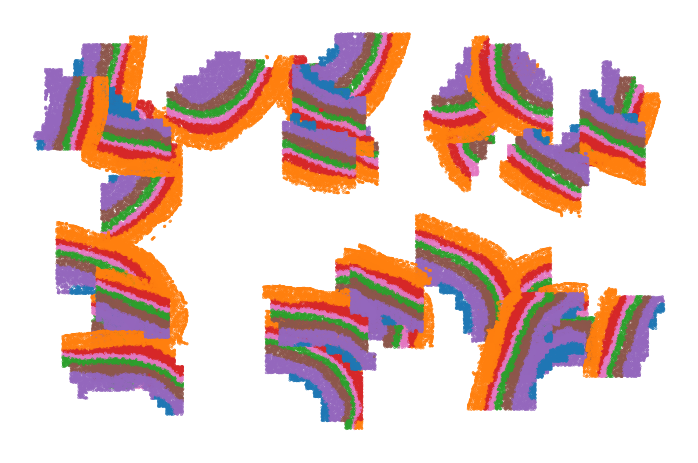

In [7]:
Scube.plot_SPACELed_slices(inputs,spatial_key='spatial',cluster_key='spa_cluster',s=.1)

## Pairwise alignment

Here, we perform pairwise alignment of slices. The `cluster_key` is the column of .obs which contain spatial domain information used for alignment. The `n_neighbors` affect how much neighbors are considered when calculate similarity of two slices. The `knn_exclude_cutoff` affect max distance of neighbors. By default, `n_neighbors = 25`and `knn_exclude_cutoff = 25` means a spot/cell in source slices consider 25 neighbors in target slices, and neighbor will be exclude when the distance of neighbos larger than the median of neareast 50 neighbors distance in all spot/cell in target slice. `p` affect the exponent of overlap penalty, and a larger `p` means smaller weight of the overlap penalty.

In [8]:
Scube.align(inputs,cluster_key='spa_cluster',n_neighbors=25,knn_exclude_cutoff=25,p=3,n_threads=10,write_loc_path='Scube_outputs/aligned_coordinates.csv')

Start alignment...
Optimization terminated successfully.
         Current function value: -0.747290
         Iterations: 3
         Function evaluations: 226
Optimization terminated successfully.
         Current function value: -0.694363
         Iterations: 3
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -0.833838
         Iterations: 3
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: -0.803926
         Iterations: 5
         Function evaluations: 439
Optimization terminated successfully.
         Current function value: -0.779809
         Iterations: 4
         Function evaluations: 342
score= 0.7472901037234445 0.7798094903471927
Optimization terminated successfully.
         Current function value: -0.698335
         Iterations: 5
         Function evaluations: 466
score= 0.6943632216018699 0.6983346556113829
Optimization terminated successfully.
         Current fu

After alignment, the new spots/cells location coordinates saved in `.obsm['spatial_aligned']` of anndata object of each slices. When `write_loc_path` provied by users, the location coordinates of all spots/cells of all slices will be saved in `write_loc_path`.

## Plot alignment results

Plot all aligned slices stacked in a single figure. 

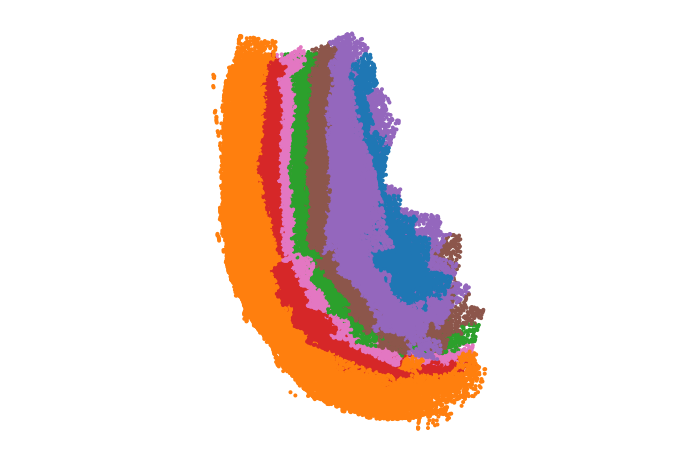

In [10]:
Scube.plot_stacked_slices(inputs,spatial_key='spatial_aligned',cluster_key='spa_cluster')

Save all spots/cells aligned coordiantes and colors in a DataFrame.

In [11]:
coo = pd.DataFrame()
for i in range(len(inputs)):
    loc = inputs[i].obsm['spatial_aligned']
    loc['celltype_colors'] = [color_map.loc[c,'color'] for c in inputs[i].obs['spa_cluster']]
    coo = pd.concat([coo,loc],axis=0)
coo.to_csv('Scube_outputs/aligned_coordinates_colors.csv')

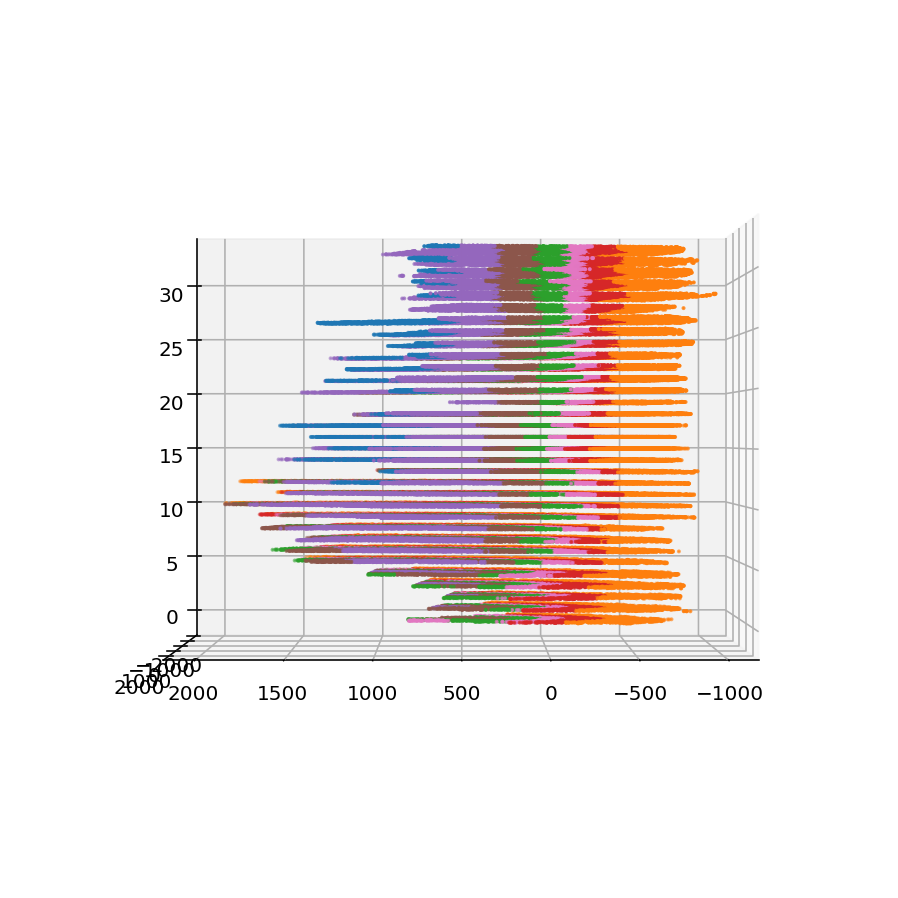

In [12]:
Scube.plot_3d(coo.values[:,:3],val=None,color=coo['celltype_colors'],show=True,elev=0,azim=90,s=1)

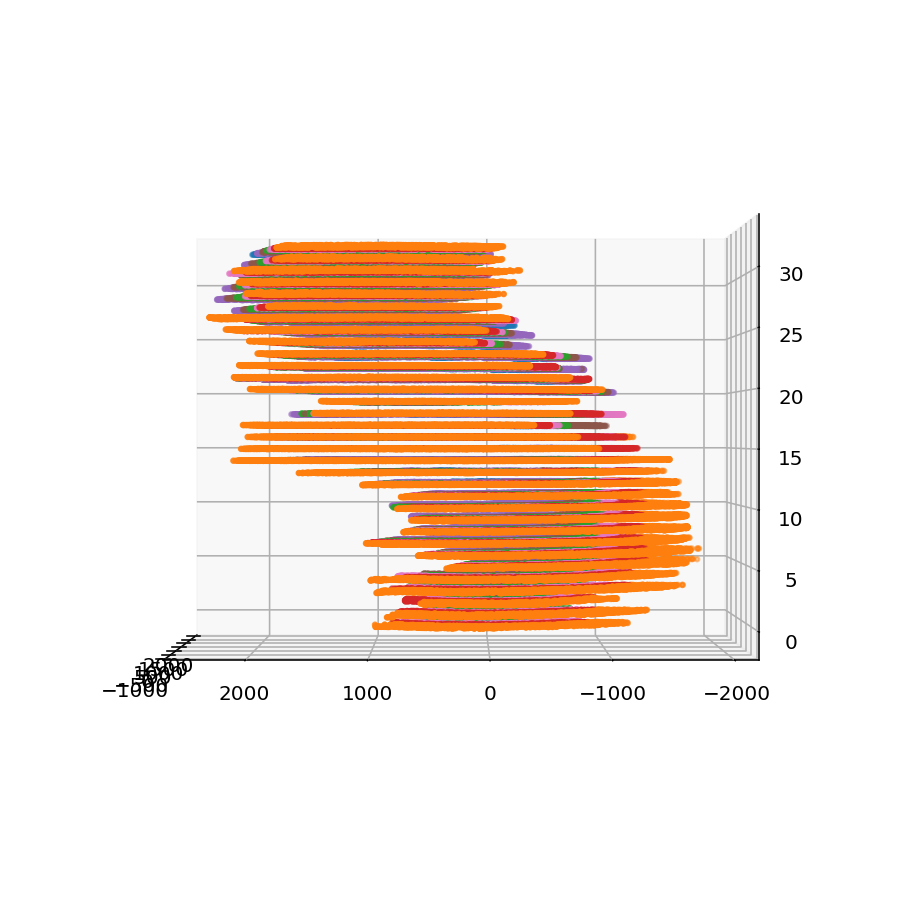

In [13]:
Scube.plot_3d(coo.values[:,:3],val=None,color=coo['celltype_colors'],show=True,elev=0,azim=180,s=5)